## Analyzing keio plate 13

This notebook runs the analysis pipeline for the preliminary data for Keio plate 9. The cut off for lysogeny was manually set.

In [1]:
#Import packages
import numpy as np 
import os
import tifffile as tiff
from skimage.io import imread
from skimage.measure import label, regionprops
import scipy
import matplotlib.pyplot as plt
import cPickle as pickle
from SLIP_functions import analyze_well, analyze_plate, segment_SLIP, plot_slip_well, plot_slip_wells
from SLIP_functions import plot_slip_joint_plot, fit_kde, compute_p_values
from SLIP_functions import classify_infections, compute_p_lysis_posterior, compute_MOI_posterior
from keio_names import get_keio_names, pos_to_strain
import seaborn as sns
import pandas as pd
import pymc3 as pm

sns.set_context('notebook', font_scale = 1.1)
sns.set_style('white')
sns.set_style('ticks')

#Activate matplotlib inline
%matplotlib inline

#Define root directory path
root_direc = '/home/vanvalen/Data/keio_screen/07.11.2017/keio_13/'
plate_number = 13

#Define directory path to infection data (all positions)
data_direc = os.path.join(root_direc, 'data')

#Define directory path to control data (all positions)
control_direc = os.path.join(root_direc, 'control')

#Define directory path to where you want to store neural net outputs. 
#mask directories must exist at run time!
mask_direc = os.path.join(root_direc, 'masks')
control_mask_direc = os.path.join(root_direc,'control_masks')

tifffile.py:156: UserWarning: failed to import the optional _tifffile C extension module.
Loading of some compressed images will be slow.
Tifffile.c can be obtained at http://www.lfd.uci.edu/~gohlke/
  "failed to import the optional _tifffile C extension module.\n"
Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 1080 (CNMeM is disabled, cuDNN 5005)


In [2]:
#Define which wells were used
row_control = ['A']
col_control = [1]

row_data = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
col_data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [3]:
#Load saved data
mean_FITC_name = os.path.join(root_direc, 'mean_FITC.pkl')
mean_cherry_name = os.path.join(root_direc, 'mean_cherry.pkl')
mean_FITC = pickle.load(open(mean_FITC_name, 'rb'))
mean_cherry = pickle.load(open(mean_cherry_name, 'rb'))

mean_FITC_control_name = os.path.join(root_direc, 'mean_FITC_control.pkl')
mean_cherry_control_name = os.path.join(root_direc, 'mean_cherry_control.pkl')
mean_FITC_control = pickle.load(open(mean_FITC_control_name, 'rb'))
mean_cherry_control = pickle.load(open(mean_cherry_control_name, 'rb'))

p_values_dict_name = os.path.join(root_direc, 'p_values_dict.pkl')
p_values_dict = pickle.load(open(p_values_dict_name, 'rb'))

IOError: [Errno 2] No such file or directory: '/home/vanvalen/Data/keio_screen/07.11.2017/keio_13/mean_FITC.pkl'

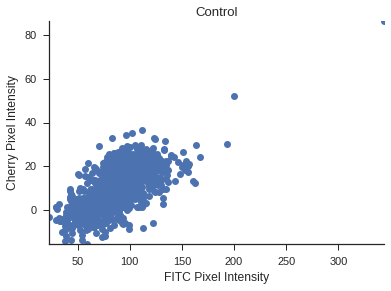

In [4]:
#Plot the data from the control plate
plot_slip_well(mean_FITC_control, mean_cherry_control, well = 'A1', title = 'Control')
sns.despine()

/home/vanvalen/.pyenv/versions/2.7.4/envs/DeepCell/lib/python2.7/site-packages/openpyxl/reader/worksheet.py:310: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


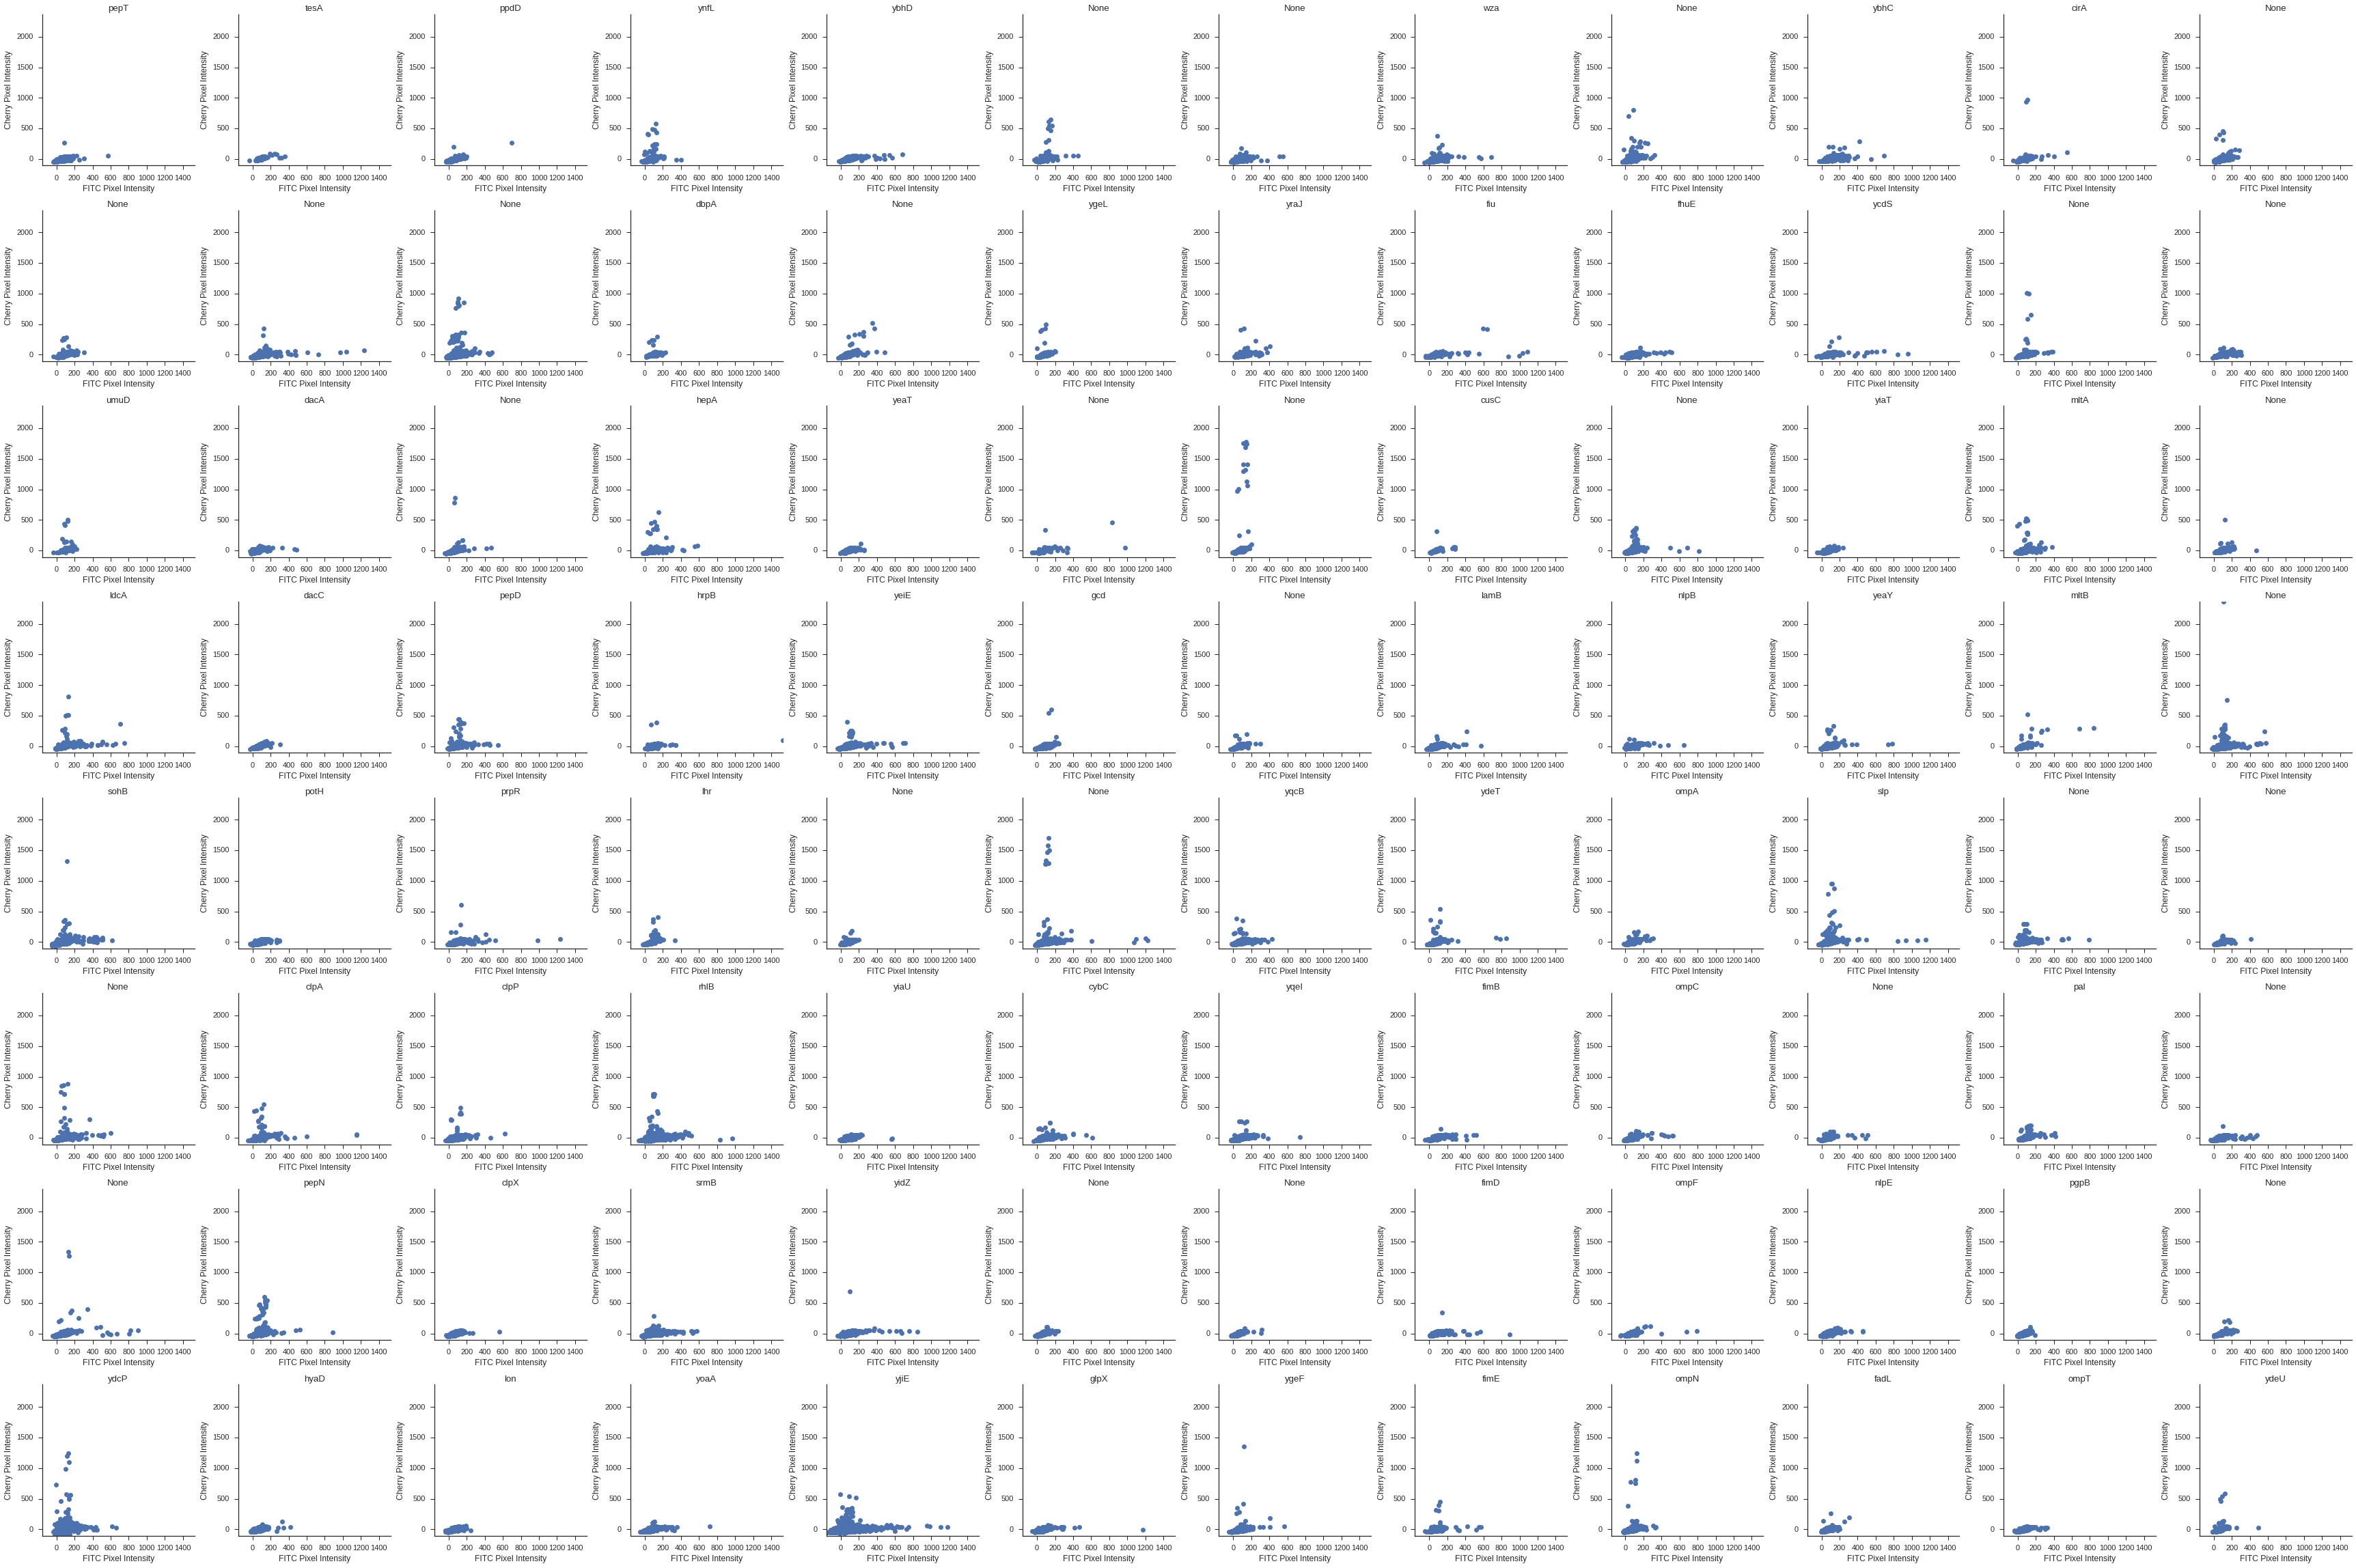

In [5]:
#Plot the scatter plot of intensities
wells = []
titles = []
keio_names_array = get_keio_names()

for row in row_data:
    for col in col_data:
        well = row + str(col)
        wells += [well]
        titles += [pos_to_strain(keio_names_array, 7, well)]
        
plot_slip_wells(mean_FITC, mean_cherry, wells = wells, titles = titles)
sns.despine()

In [6]:
#Print the number of cells in each well
for key in mean_FITC_control.keys():
    print key, len(mean_FITC_control[key])
    
for key in mean_FITC.keys():
    print key, len(mean_FITC[key])

A1 950
G7 564
G6 280
G5 1053
G4 1891
G3 726
G2 1843
G1 1230
G9 390
G8 299
B4 117
B5 388
B6 193
B7 202
B1 638
B2 1927
B3 4928
B8 535
B9 1628
E9 659
E8 440
E5 317
E4 302
E7 575
E6 1687
E1 639
E3 822
E2 1215
H10 322
H11 478
H12 299
F12 787
F10 369
F11 400
H8 367
H9 1102
H2 529
H3 658
H1 3369
H6 583
H7 1706
H4 1041
H5 22620
D10 557
D11 368
D12 1546
B12 297
B10 326
B11 341
C9 1003
C8 84
C3 606
C2 293
C1 156
C7 277
C6 213
C5 317
C4 894
G12 176
G11 555
G10 1509
F1 1665
F2 2304
F3 1726
F4 6928
F5 1075
F6 1046
F7 892
F8 751
F9 782
E11 774
E10 889
E12 179
C12 172
C11 840
C10 239
A11 326
A10 591
A12 612
A1 539
A3 392
A2 119
A5 712
A4 950
A7 2304
A6 414
A9 1141
A8 1973
D8 1244
D9 282
D6 504
D7 367
D4 535
D5 1023
D2 194
D3 786
D1 709


In [7]:
# Fit a KDE estimator to the no infection control
kernel = fit_kde(mean_FITC_control, mean_cherry_control, 'A1')

In [8]:
#Compute the fraction infected in each well and plot
conc_list = []
fraction_infected_list = []
for well in p_values_dict.keys():
    p_value = p_values_dict[well]
    fraction_infected = np.float(np.where(p_value < 0.01)[0].shape[0])/np.float(p_value.shape[0])
    fraction_infected_list += [fraction_infected]
    
    print well, fraction_infected

G7 0.164893617021
G6 0.182142857143
G5 0.225071225071
G4 0.238498149127
G3 0.242424242424
G2 0.256104177971
G1 0.223577235772
G9 0.187179487179
G8 0.33779264214
B4 0.282051282051
B5 0.239690721649
B6 0.222797927461
B7 0.391089108911
B1 0.236677115987
B2 0.271925272444
B3 0.157873376623
B8 0.2
B9 0.164619164619
E9 0.230652503794
E8 0.252272727273
E5 0.227129337539
E4 0.311258278146
E7 0.27652173913
E6 0.260818020154
E1 0.316118935837
E3 0.312652068127
E2 0.18683127572
H10 0.189440993789
H11 0.152719665272
H12 0.234113712375
F12 0.196950444727
F10 0.216802168022
F11 0.39
H8 0.209809264305
H9 0.211433756806
H2 0.189035916824
H3 0.203647416413
H1 0.247848026121
H6 0.173241852487
H7 0.200468933177
H4 0.157540826129
H5 0.122634836428
D10 0.231597845601
D11 0.350543478261
D12 0.246442432083
B12 0.299663299663
B10 0.276073619632
B11 0.307917888563
C9 0.250249252243
C8 0.238095238095
C3 0.244224422442
C2 0.252559726962
C1 0.365384615385
C7 0.285198555957
C6 0.272300469484
C5 0.246056782334
C4 0

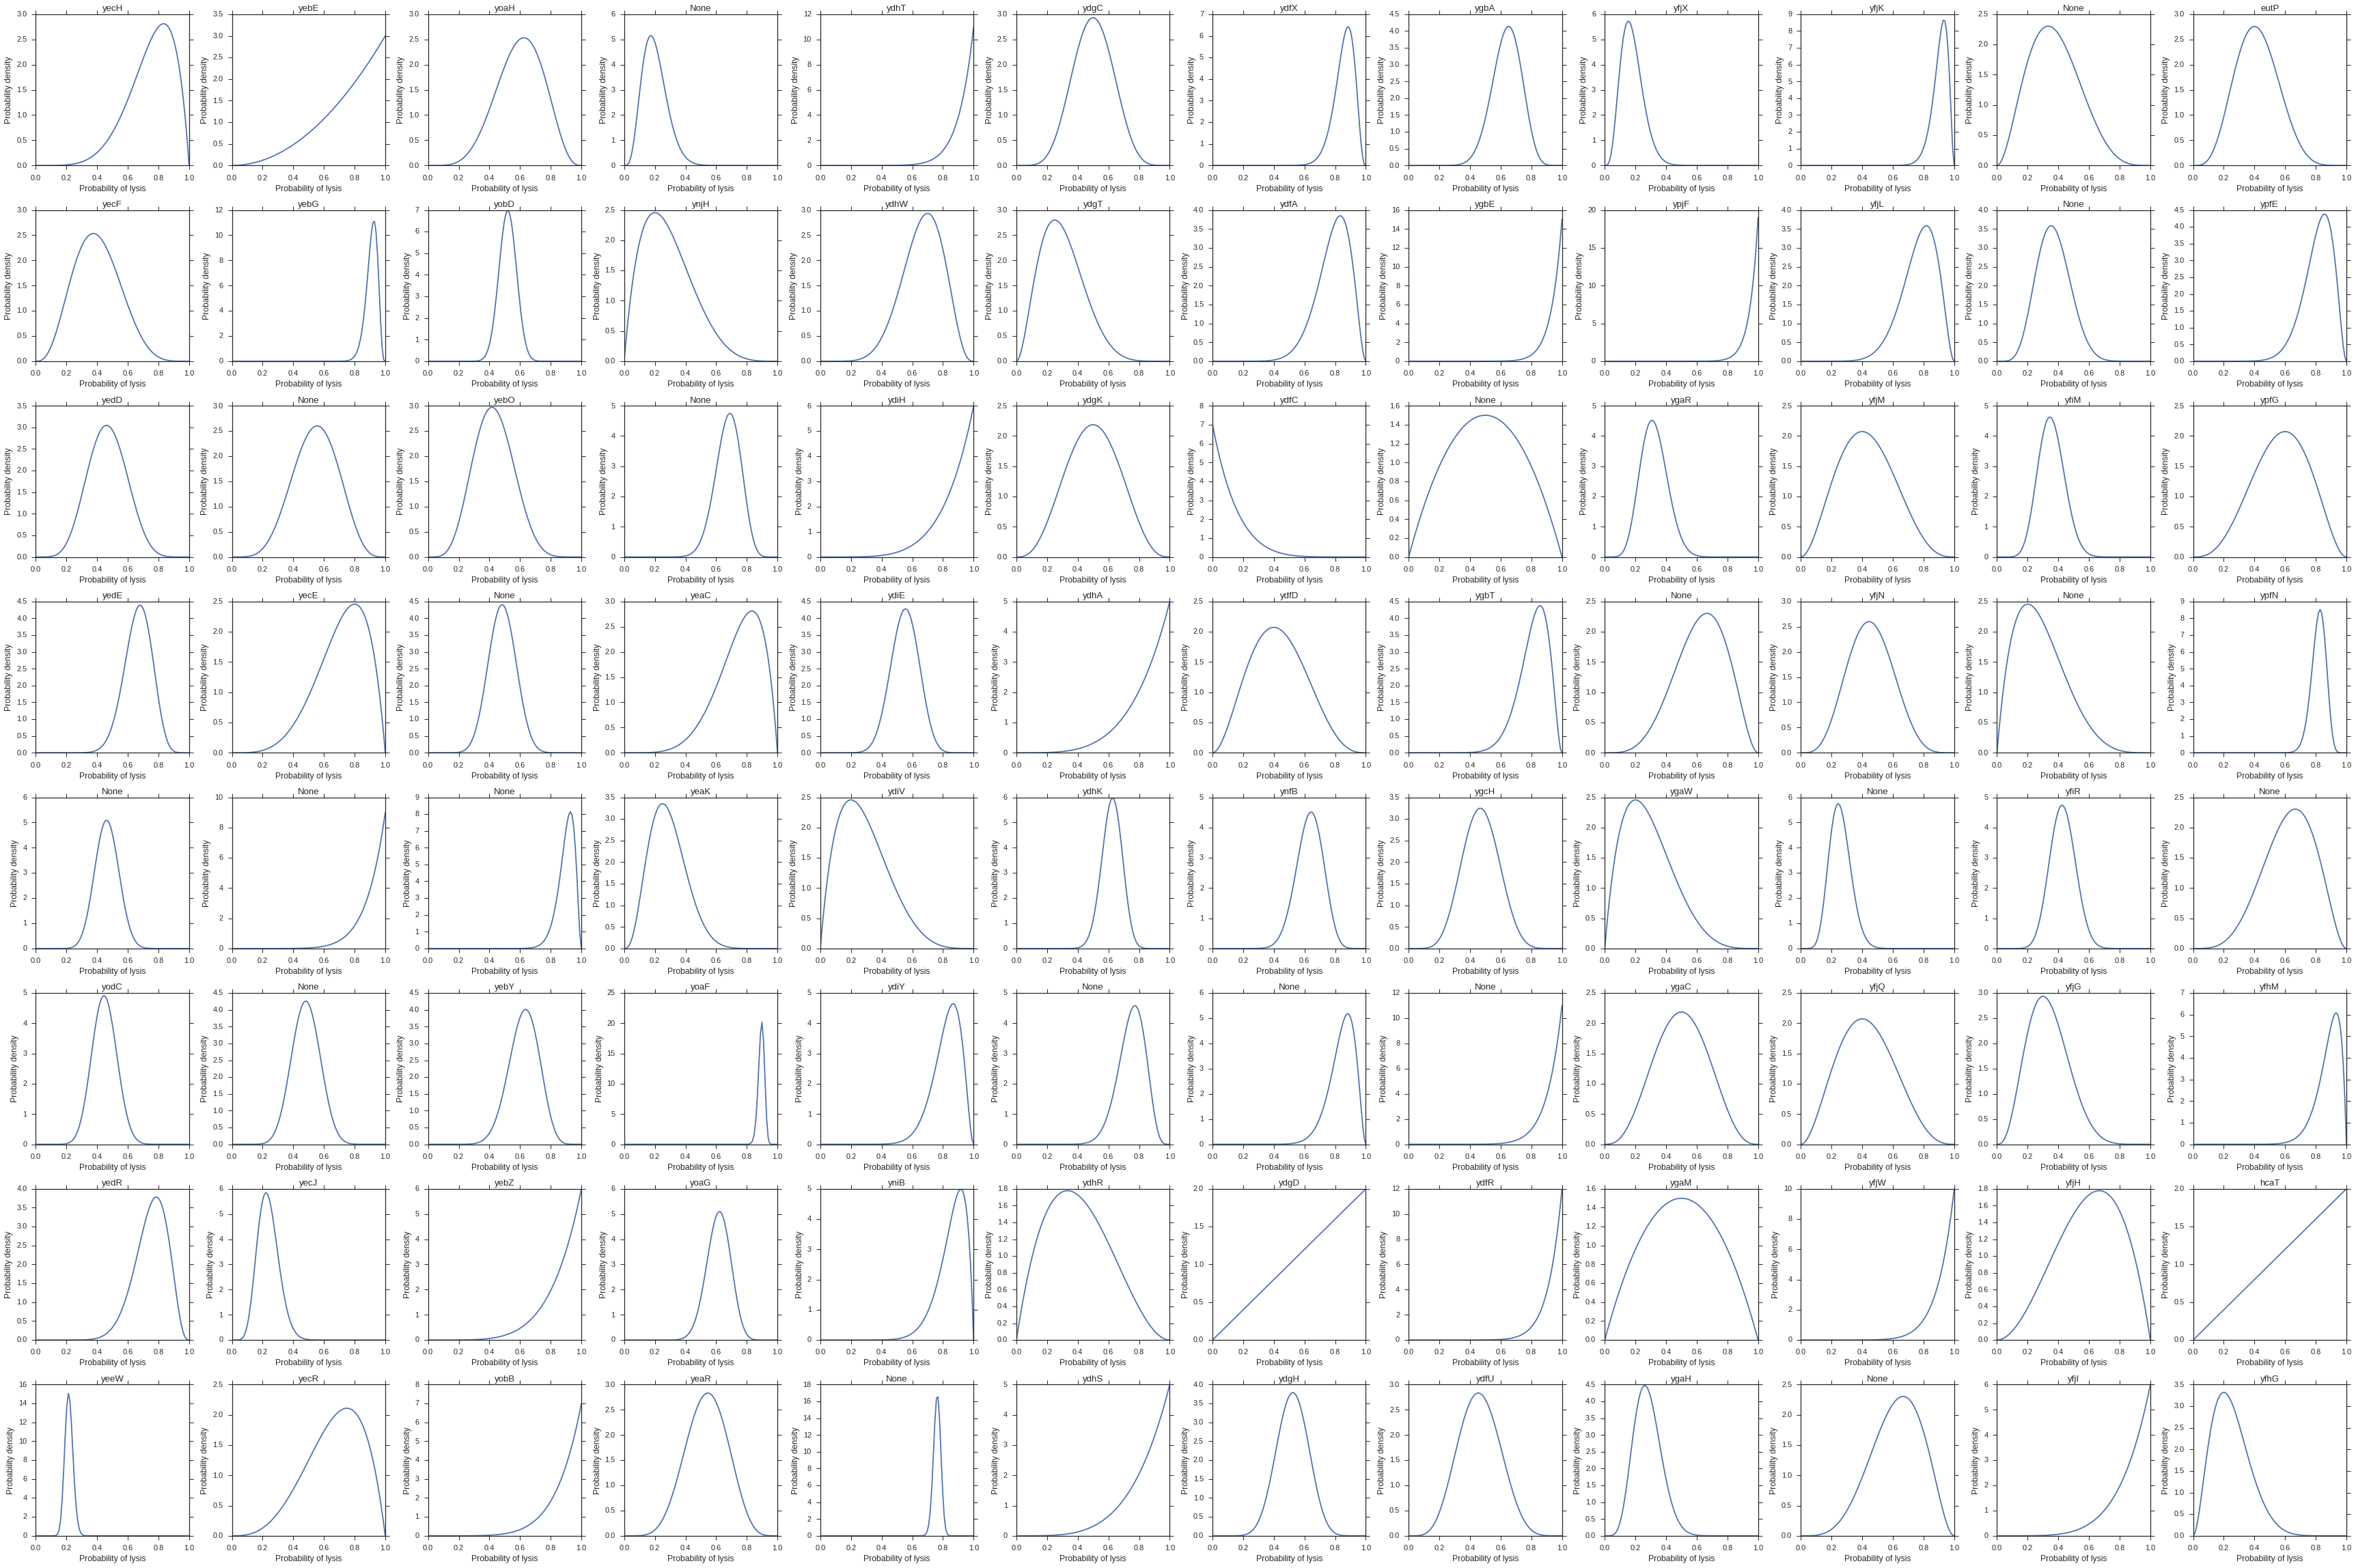

In [9]:
# Use the no phage control to construct a lysis/lysogeny classifier
fitc_control_array = np.array(mean_FITC_control['A1'])
cherry_control_array = np.array(mean_cherry_control['A1'])
kernel_fitc = scipy.stats.gaussian_kde(fitc_control_array)
kernel_cherry = scipy.stats.gaussian_kde(cherry_control_array)

def compute_p_lysis_posterior(N_lysis, N_lysogeny):
    x = np.linspace(0,1,100)
    posterior= scipy.stats.beta.pdf(x, 1+N_lysis, 1+N_lysogeny)
    return x, posterior

# d = classify_infections(kernel_fitc, kernel_cherry, p_values_dict, rows = row_data, cols = col_data)

kn = get_keio_names()
fig, axes = plt.subplots(8,12, figsize = (4*12, 4*8))

for row in row_data:
    for col in col_data:
        well = row + str(col)
        
        well_name = pos_to_strain(kn, plate = plate_number, pos = well)
        p_value = p_values_dict[well]
        infected_cells = np.where(p_value < 0.01)[0]
        fitc_list = np.array(mean_FITC[well])[infected_cells]
        cherry_list = np.array(mean_cherry[well])[infected_cells]

        p_fitc = []
        p_cherry = []
        for fitc, cherry in zip(fitc_list, cherry_list):
            p_fitc += [1-kernel_fitc.integrate_box_1d(fitc, 1e6)]
            p_cherry += [1-kernel_cherry.integrate_box_1d(cherry, 1e6)]

        # Remove double positives
        p_fitc_new = []
        p_cherry_new = []
        fitc_list_new = []
        cherry_list_new = []
        for p_f, p_c, f, c in zip(p_fitc, p_cherry, fitc_list, cherry_list):
            if (p_f < 0.85 and c > 50) or p_c < 0.85:
                p_fitc_new += [p_f]
                p_cherry_new += [p_c]
                fitc_list_new += [f]
                cherry_list_new += [c]

        p_fitc = p_fitc_new
        p_cherry = p_cherry_new
        fitc_list = fitc_list_new
        cherry_list = cherry_list_new

        d = {'FITC Probability': p_fitc, 'Cherry Probability': p_cherry}
        dataframe = pd.DataFrame(data = d)
#         grid = sns.lmplot('FITC Probability', 'Cherry Probability', dataframe, fit_reg = False)
#         ax = grid.axes[0][0]
#         ax.set_title(well_name)
#         ax.set_xlim([-0.05, 1.05])
#         ax.set_ylim([-0.05, 1.05])

        d = {'FITC Intensity': fitc_list, 'Cherry Intensity': cherry_list}
        dataframe = pd.DataFrame(data = d)
#         grid = sns.lmplot('FITC Intensity', 'Cherry Intensity', dataframe, fit_reg = False, scatter_kws = {'color': 'red'})
#         ax = grid.axes[0][0]
#         ax.set_title(well_name)

        counter = 0
        for p_f, p_c in zip(p_fitc, p_cherry):
            if p_f > p_c:
                counter += 1
                
        if len(p_fitc) > 0:
            #Uncomment to print p_lysis
            #print well_name, np.float(counter)/len(p_fitc), counter, len(p_fitc)
            
            x, posterior = compute_p_lysis_posterior(counter, len(p_fitc) - counter)
            
            alphabet = ['A','B','C','D','E','F','G','H']
            chars = list(well)
            row_temp = alphabet.index(chars[0])
            if len(chars) == 2:
                col_temp = int(chars[1])-1
            if len(chars) == 3:
                col_temp = int(chars[1] + chars[2])-1
                
            axes[row_temp, col_temp].plot(x, posterior)
            axes[row_temp, col_temp].set_xlim([0, 1])
            axes[row_temp, col_temp].set_xlabel('Probability of lysis')
            axes[row_temp, col_temp].set_ylabel('Probability density')
            axes[row_temp, col_temp].set_title(well_name)
        else:    
            alphabet = ['A','B','C','D','E','F','G','H']
            chars = list(well)
            row_temp = alphabet.index(chars[0])
            if len(chars) == 2:
                col_temp = int(chars[1])-1
            if len(chars) == 3:
                col_temp = int(chars[1] + chars[2])-1
                
            axes[row_temp, col_temp].plot(x, posterior)
            axes[row_temp, col_temp].set_xlim([0, 1])
            axes[row_temp, col_temp].set_xlabel('Probability of lysis')
            axes[row_temp, col_temp].set_ylabel('Probability density')
            axes[row_temp, col_temp].set_title(well_name)
            
plt.tight_layout()
    

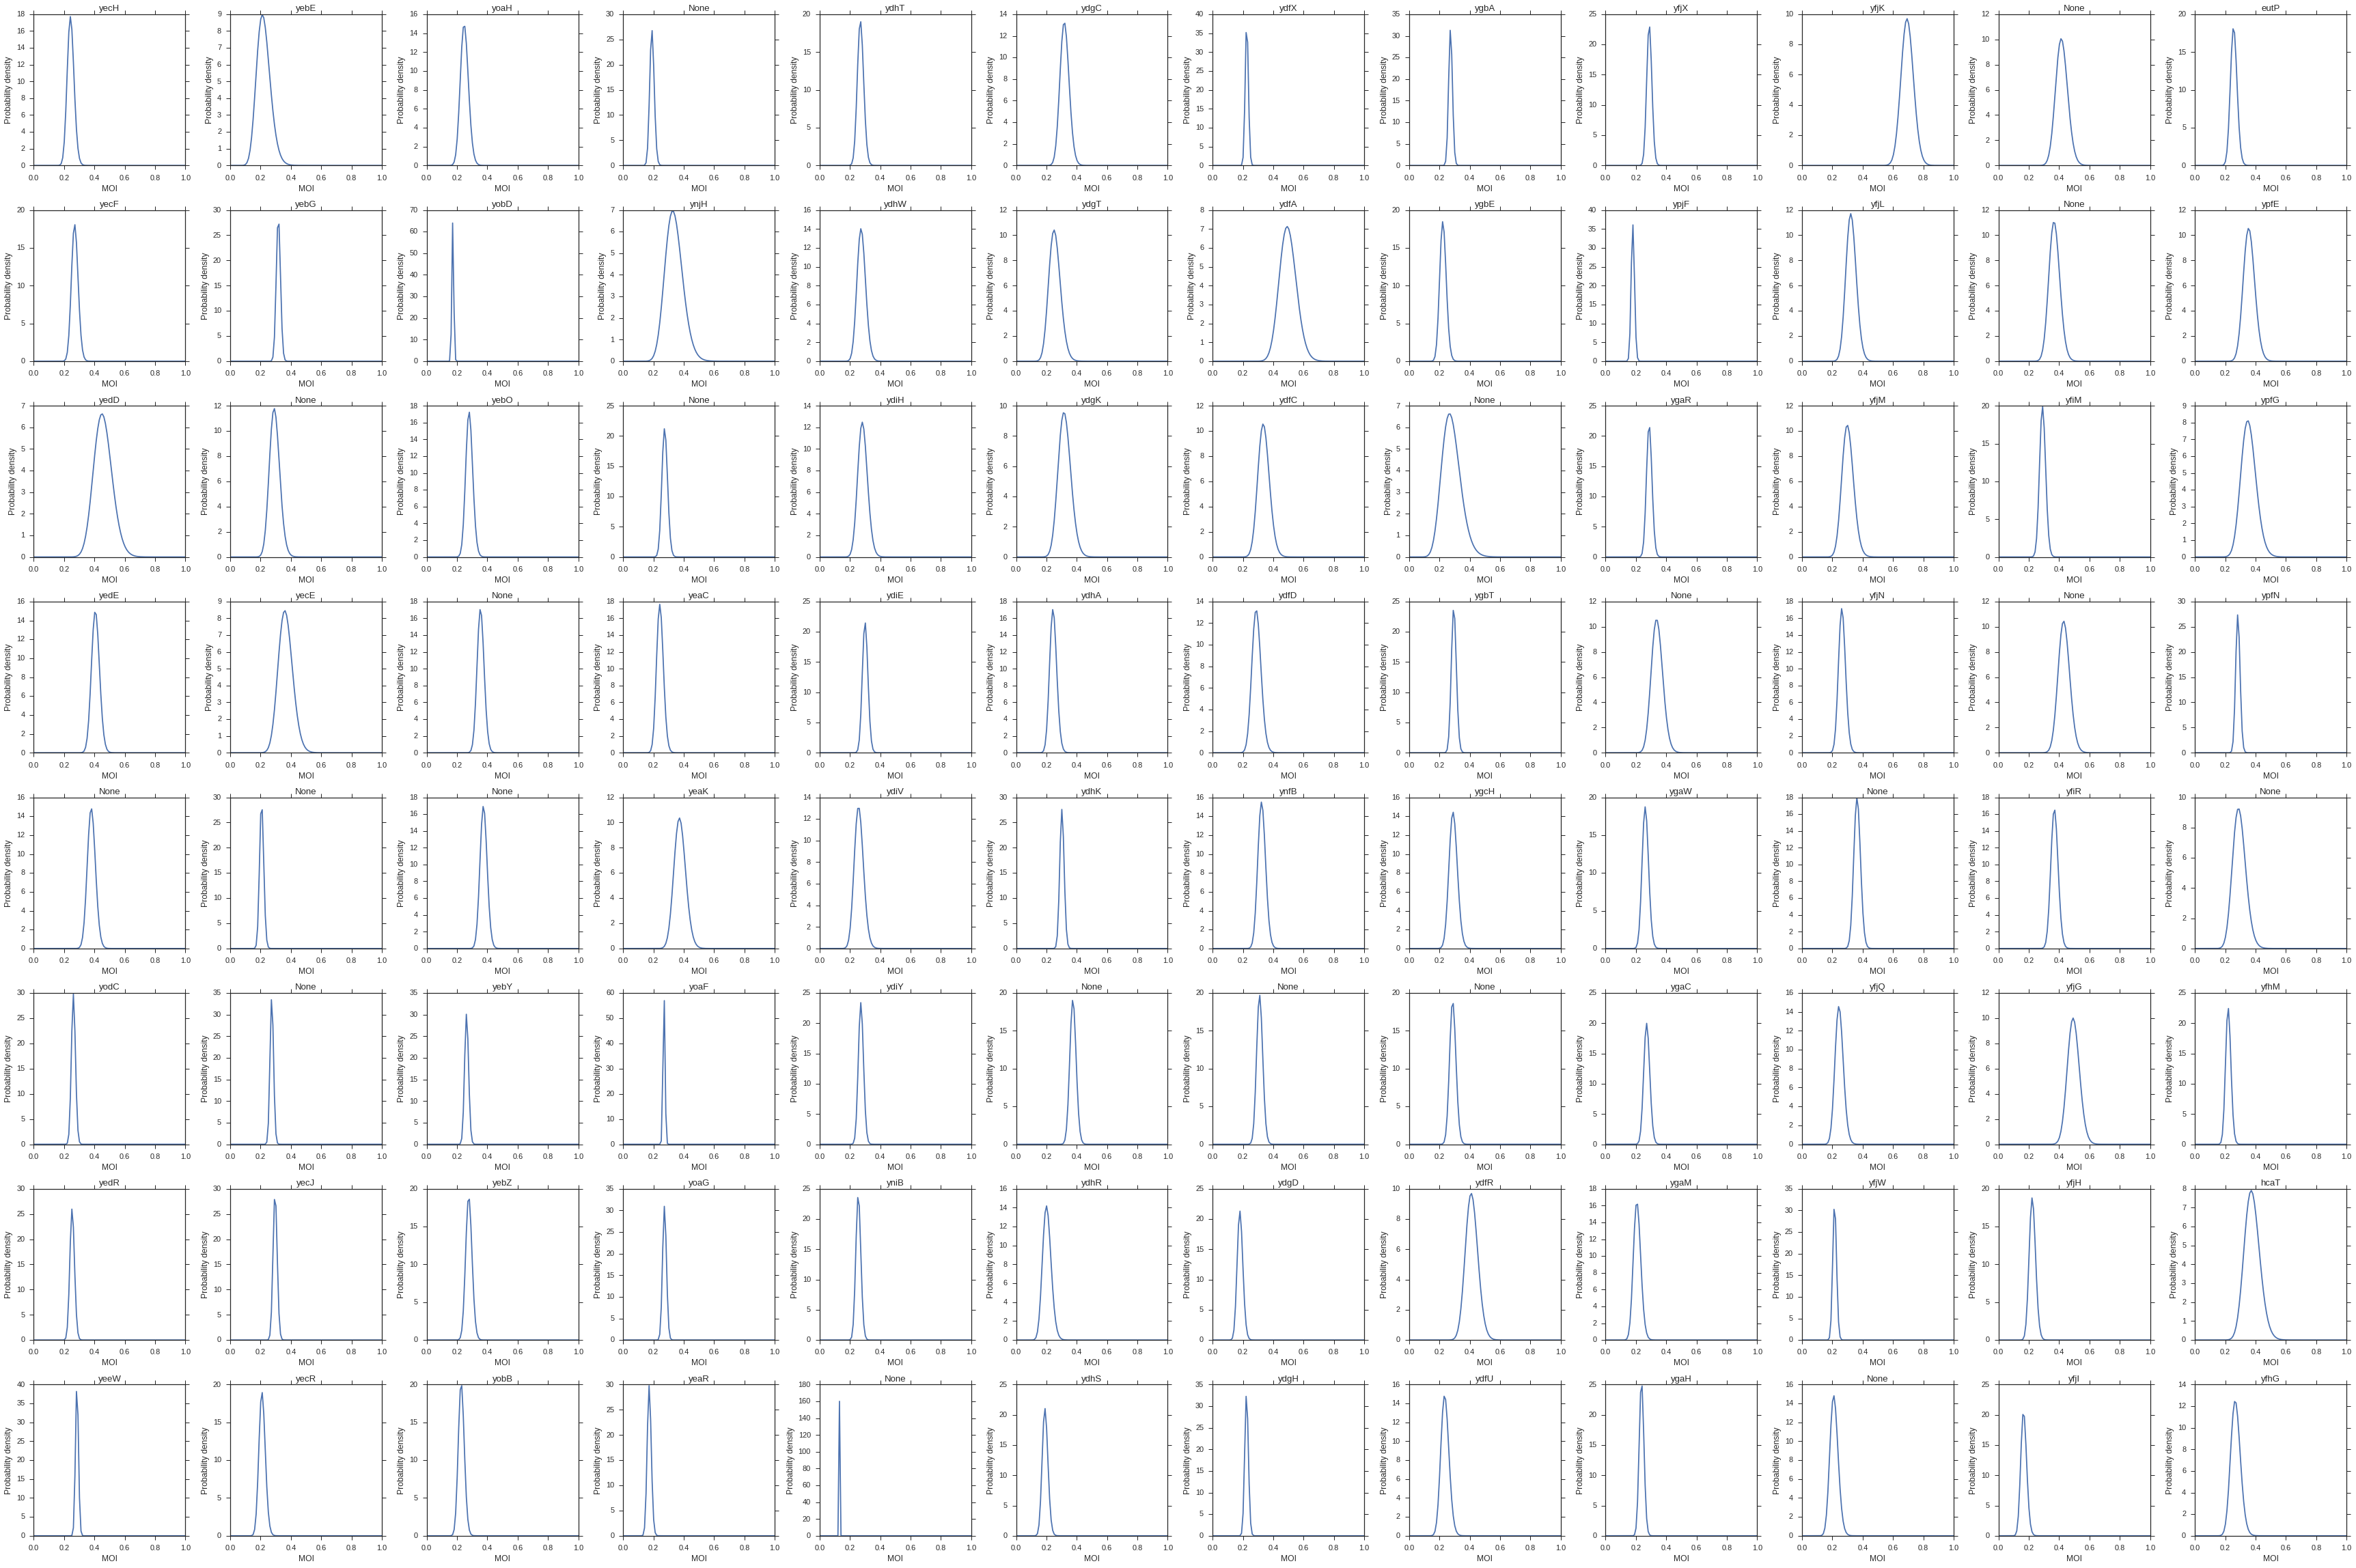

In [11]:
fig, axes = plt.subplots(8,12, figsize = (4*12, 4*8))

def compute_inverse_MOI_posterior(N_infected, N_cells):
    x = np.linspace(0,2,200)
    gamma = np.float(N_cells)*np.log(1-1/np.float(N_cells))
    posterior = np.abs(gamma*np.exp(gamma*x))*scipy.stats.beta.pdf(np.exp(gamma*x), 1+N_cells-N_infected, 1+N_infected)

    return x, posterior

kn = get_keio_names()

for row in row_data:
    for col in col_data:
        well = row + str(col)
        
        well_name = pos_to_strain(kn, plate = plate_number, pos = well)
        p_value = p_values_dict[well]
        infected_cells = np.where(p_value < 0.01)[0]
        fitc_list = np.array(mean_FITC[well])[infected_cells]
        cherry_list = np.array(mean_cherry[well])[infected_cells]

        p_fitc = []
        p_cherry = []
        for fitc, cherry in zip(fitc_list, cherry_list):
            p_fitc += [1-kernel_fitc.integrate_box_1d(fitc, 1e6)]
            p_cherry += [1-kernel_cherry.integrate_box_1d(cherry, 1e6)]

        # Remove double positives
        p_fitc_new = []
        p_cherry_new = []
        fitc_list_new = []
        cherry_list_new = []
        for p_f, p_c, f, c in zip(p_fitc, p_cherry, fitc_list, cherry_list):
            if (p_f < 0.85 and c > 50) or p_c < 0.85:
                p_fitc_new += [p_f]
                p_cherry_new += [p_c]
                fitc_list_new += [f]
                cherry_list_new += [c]

        p_fitc = p_fitc_new
        p_cherry = p_cherry_new
        fitc_list = fitc_list_new
        cherry_list = cherry_list_new

        counter = 0
        for p_f, p_c in zip(p_fitc, p_cherry):
            if p_f > p_c:
                counter += 1
                
        if len(p_fitc) > 0:
            #Uncomment to print p_lysis
            #print well_name, np.float(counter)/len(p_fitc), counter, len(p_fitc)
            x, posterior = compute_inverse_MOI_posterior(infected_cells.shape[0], p_value.shape[0])
            
            alphabet = ['A','B','C','D','E','F','G','H']
            chars = list(well)
            row_temp = alphabet.index(chars[0])
            if len(chars) == 2:
                col_temp = int(chars[1])-1
            if len(chars) == 3:
                col_temp = int(chars[1] + chars[2])-1
                
            axes[row_temp, col_temp].plot(x, posterior)
            axes[row_temp, col_temp].set_xlim([0, 1])
            axes[row_temp, col_temp].set_xlabel('MOI')
            axes[row_temp, col_temp].set_ylabel('Probability density')
            axes[row_temp, col_temp].set_title(well_name)
        else:    
            alphabet = ['A','B','C','D','E','F','G','H']
            chars = list(well)
            row_temp = alphabet.index(chars[0])
            if len(chars) == 2:
                col_temp = int(chars[1])-1
            if len(chars) == 3:
                col_temp = int(chars[1] + chars[2])-1
                
            axes[row_temp, col_temp].plot(x, posterior)
            axes[row_temp, col_temp].set_xlim([0, 1])
            axes[row_temp, col_temp].set_xlabel('MOI')
            axes[row_temp, col_temp].set_ylabel('Probability density')
            axes[row_temp, col_temp].set_title(well_name)
            
plt.tight_layout()